## This file is a demo showing how the inference algorithm works on a HARISSA simulation

In [1]:
# %matplotlib notebook
import numpy as np
import pandas as pd
import sys
import sklearn
sys.path.append('../Utils')
sys.path.append('../Data')
#import torch
from utils_Velo import *

from utils import *
import scipy
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Take HARISSA data for example, its first 2 PCs are visualized below

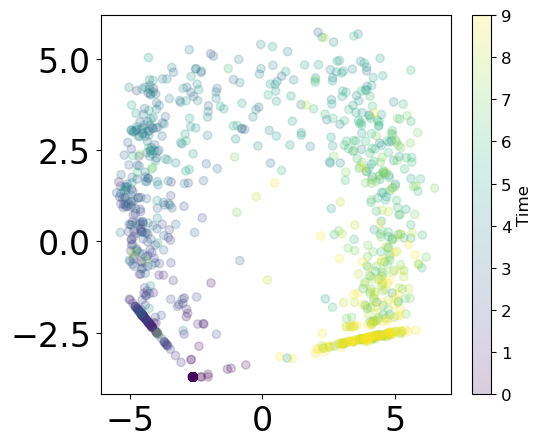

In [5]:
plt.rcParams["figure.figsize"] = (6,5)
plt.rcParams["font.size"] = 8
counter = -1
alpha = 0.5
dt = [1]*10
eps_samp = 1E-2

Nt = 10

example = 'FN8'

scale = 20

FileName = '../Data/HARISSA/'+example+'/Data/data_8.txt'
        
counts = np.loadtxt(FileName)
counts[2::,:] = np.log( counts[2::,:] + 1)
        
    # counts = counts[2::,1::]
counts = counts[1::,1::]
n = counts.shape[0]
        
    
        
    
num_cells_per_step = int( counts.shape[1]/Nt )
        
labels = np.zeros((1,num_cells_per_step*Nt))
        
        
counts_all = [[0]]*Nt
for i in range(Nt):
    counts_all[i] =  counts[:,i*num_cells_per_step:(i+1)*num_cells_per_step]  
            
       
    labels[0,i*num_cells_per_step:(i+1)*num_cells_per_step] = i
group_labels = list(range(Nt))
for i in range(Nt):
    group_labels[i] = str(group_labels[i])

n = counts.shape[0]
counts_pca, pca = visualize_pca(counts[1::,:],labels,group_labels,viz_opt='pca')
        
sc = plt.scatter(counts_pca[:,0], counts_pca[:,1],c=labels[0][:], alpha=0.2 )

cb = plt.colorbar(sc)#,label='Time',fontsize=12)
cb.set_label(label='Time',size=12)
cb.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

## First we show how to compute and visualize the velocity:

/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhor

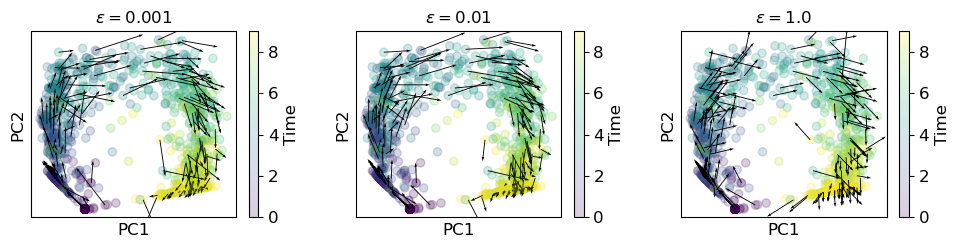

In [6]:
alpha = 0.5


plt.rcParams["figure.figsize"] = (10,3)
for eps in [1E-3, 1E-2, 1E0]:
    counter += 1
    
    Ts_prior,_ = solve_prior(counts[1:,:],counts[1:,:], Nt, labels, eps_samp=eps, alpha=alpha)


    velocities_all_pca = [ [0] ]*(Nt)
    nums = []
    for i in range(Nt):
        nums = nums + [ counts_all[i].shape[1] ]
          
    
    i = 0
    velocities_all_pca[i] = [0]
    count_t_mapped = nums[i]*np.matmul( counts_all[i+1],Ts_prior[i].T )
        
    velocities_all_pca[i] = (pca.transform( count_t_mapped[1:,:].T ) - pca.transform( counts_all[i][1:,:].T ))/dt[i]
    
    
    for i in range(1,Nt-1):
        velocities_all_pca[i] = [0]
        count_t_mapped = nums[i]*np.matmul( counts_all[i+1],Ts_prior[i].T )
        
        velocities_all_pca[i] = pca.transform( count_t_mapped[1::,:].T ) - pca.transform( counts_all[i][1:,:].T )
        count_t_mapped = nums[i]*np.matmul( counts_all[i-1],Ts_prior[i-1] )
        velocities_all_pca[i] = velocities_all_pca[i]/2/dt[i] + (pca.transform( counts_all[i][1:,:].T ) - pca.transform( count_t_mapped[1:,:].T ))/2/dt[i-1]
       
    i = Nt-1
    
    count_t_mapped = nums[i]*np.matmul( counts_all[i-1],Ts_prior[i-1] )
    velocities_all_pca[i] = ( pca.transform(counts_all[i][1:,:].T) - pca.transform( count_t_mapped[1:,:].T ) )/dt[i-1]
    
    velocities_pca = np.zeros( (n-1, (Nt)*num_cells_per_step))
    
    for i in range(Nt):
        
        velocities_pca[:,i*num_cells_per_step:(i+1)*num_cells_per_step] = velocities_all_pca[i].T
    #plt.subplot(1,4,counter)
    plt.scatter(counts_pca[:,0], counts_pca[:,1],c=labels, alpha=0.01 )
    # plt.colorbar()
    # velocities_pca = pca.transform( velocities_signed.T)
    Num_cell = counts_pca.shape[0]
    idx_subsamp = range(0,Num_cell,5)
    plt.subplot(1,3,counter+1)

    sc = plt.scatter(counts_pca[:,0], counts_pca[:,1],c=labels[0][:], alpha=0.2 )
    plt.quiver( counts_pca[idx_subsamp,0],counts_pca[idx_subsamp,1],velocities_pca[0,idx_subsamp] , velocities_pca[1,idx_subsamp], scale=scale )
    plt.xlabel('PC1',fontsize=12)
    plt.ylabel('PC2',fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    cb = plt.colorbar(sc)#,label='Time',fontsize=12)
    cb.set_label(label='Time',size=12)
    cb.ax.tick_params(labelsize=12)
    plt.title(r'$\epsilon=$'+str(eps),fontsize=12)
    #plt.show()

plt.show()

After solving for the velocity, one can run inference and compare with ground truth. The cell below loads ground truth of the network, which is a signed matrix representing the weights.

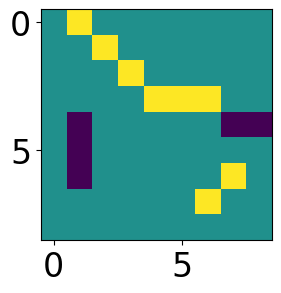

In [12]:
FileName = '../Data/HARISSA/'+example+'/True/inter_signed.npy'
truth = np.load(FileName)
truth = truth - np.diag ( np.diag( truth ) )
import scipy.io
#scipy.io.savemat( '../Figures/HARISSA/truth.mat',mdict={'truth':truth} )
plt.imshow(truth)

In [14]:
# Compute velocity
Ts_prior,_ = solve_prior(counts[1:,:],counts[1:,:], Nt, labels, eps_samp=1E-2, alpha=0.5)
velocities_all, velocities_all_signed = solve_velocities( counts_all, Ts_prior, order = 1,stimulation=True)
        
velocities = np.zeros( (n, (Nt)*num_cells_per_step))
velocities_signed = np.zeros( (n, (Nt)*num_cells_per_step))
        
for i in range(Nt):
            
    velocities[:,i*num_cells_per_step:(i+1)*num_cells_per_step] = velocities_all[i]
    velocities_signed[:,i*num_cells_per_step:(i+1)*num_cells_per_step] = velocities_all_signed[i]
        


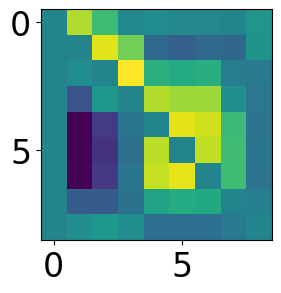

In [17]:
# Run the correlation approach
import copy
velocities_all_signed_copy = copy.deepcopy( velocities_all_signed )
velocities_signed_copy = copy.deepcopy( velocities_signed )
Tv_corr = OT_lagged_correlation(velocities_all_signed_copy, velocities_signed_copy, Ts_prior, stimulation=True, 
                                 elastic_Net=False,tune=False,signed=True )       

Tv_corr = Tv_corr - np.diag( np.diag(Tv_corr) )
plt.imshow(Tv_corr)
plt.show()

/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/wenjunzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


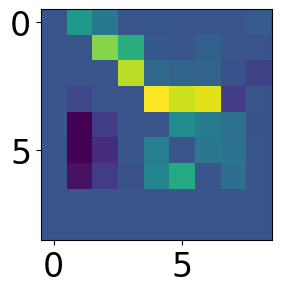

In [18]:
Tv_Granger = OT_lagged_correlation(velocities_all_signed_copy, velocities_signed_copy, Ts_prior, stimulation=True, 
                                 elastic_Net=True,l1_opt=0.5,tune=False,signed=True )       

Tv_Granger = Tv_Granger - np.diag( np.diag(Tv_Granger) )
plt.imshow(Tv_Granger)
plt.show()

## Now we can quantify the performance via some metrics. For example, the cell below shows AUPRC

In [23]:
import evaluation_metrics
from evaluation_metrics import evaluate_AUC, early_precision#,stability

AUPRC, AUROC, random = evaluate_AUC( Tv_corr, truth, sign = None)
print('AUPRC='+str(AUPRC) )
print('AUROC='+str(AUROC) )

AUPRC=0.48824222252855326
AUROC=0.848761408083442


In [24]:
AUPRC, AUROC, random = evaluate_AUC( Tv_Granger, truth, sign = None)
print('AUPRC='+str(AUPRC) )
print('AUROC='+str(AUROC) )

AUPRC=0.7390720833058293
AUROC=0.8774445893089962


## Signed metric considers a prediction as correct only if the regulation type is correct too

In [26]:
AUPRC, AUROC, random = evaluate_AUC( Tv_corr, truth, sign = True)
print('signed AUPRC='+str(AUPRC) )
print('signed AUROC='+str(AUROC) )

signed AUPRC=0.4930204980148845
signed AUROC=0.8483883818629582


In [28]:
AUPRC, AUROC, random = evaluate_AUC( Tv_Granger, truth, sign = True )
print('signed AUPRC='+str(AUPRC) )
print('signed AUROC='+str(AUROC) )

signed AUPRC=0.7338313218120911
signed AUROC=0.8703742937853107
